In [2]:
from shapely.geometry import Point
import geopandas as gpd
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr

## Load GSP region data

In [27]:
OSGB_EPSG = 27700
WGS84_EPSG = 4326

In [3]:
GSP_SHAPE_PATH = Path("~/dev/ocf/nowcasting_dataset/nowcasting_dataset/data_sources/gsp/gsp_shape/").expanduser()
ESO_METADATA_FILENAME = Path("~/dev/ocf/nowcasting_dataset/nowcasting_dataset/data_sources/gsp/eso_metadata.csv").expanduser()
gsp_shape = gpd.read_file(GSP_SHAPE_PATH)
eso_metadata = pd.read_csv(ESO_METADATA_FILENAME, usecols=["gsp_id", "region_id"]).dropna()

In [4]:
gsp_shape = gsp_shape.rename(columns={"RegionID": "region_id"})
gsp_shape

,region_id,RegionName,cen_x,cen_y,cen_lat,cen_lon,geometry
0,149,Beddington (_J),536188.353965,153184.379039,51.261557,-0.049493,"POLYGON ((543750.561 167428.882, 549430.486 13..."
1,150,Northfleet East,562905.369691,156371.196102,51.283187,0.334557,"POLYGON ((571652.936 143992.711, 550968.129 13..."
2,155,Sellindge,603591.567662,135280.229043,51.080709,0.905299,"POLYGON ((624923.598 137169.470, 624894.947 13..."
3,160,Richborough,631523.349693,156148.808737,51.257472,1.316827,"POLYGON ((626375.397 137910.687, 623652.026 16..."
4,156,Chessington,517564.146384,155903.402341,51.290137,-0.315393,"POLYGON ((523319.962 166572.557, 526121.634 14..."
...,...,...,...,...,...,...,...
324,60,Iron Acton,360399.106146,175513.972539,51.477188,-2.571607,"MULTIPOLYGON (((371321.522 169758.107, 369859...."
325,67,Landulph,236193.727900,66565.874760,50.475953,-4.309967,"MULTIPOLYGON (((238210.000 33959.000, 238174.0..."
326,18,Melksham,374787.393690,164683.411687,51.380632,-2.363658,"POLYGON ((374188.174 155409.620, 372306.229 16..."
327,61,Seabank,355968.140244,156065.443846,51.301994,-2.632987,"MULTIPOLYGON (((323330.000 160670.000, 323300...."


In [5]:
for col_name in ["gsp_id", "region_id"]:
    eso_metadata[col_name] = eso_metadata[col_name].astype(np.int32)

eso_metadata = eso_metadata.set_index("region_id").sort_index()

In [6]:
gsp_shape = gsp_shape.join(eso_metadata, on="region_id", how="outer")
gsp_shape = gsp_shape.set_index("gsp_id").sort_index()
gsp_shape = gsp_shape["geometry"]

In [7]:
# Loop through any GSP IDs associated with multiple regions and replace
# these duplicated entries with a single entry where the geometry is the 
# union of the geometries.
gsp_ids_with_multiple_rows = gsp_shape.index[gsp_shape.index.duplicated()]
for gsp_id in gsp_ids_with_multiple_rows:
    unary_union = gsp_shape.loc[gsp_id].unary_union
    gsp_shape.drop(gsp_id, axis="index", inplace=True)
    gsp_shape.loc[gsp_id] = unary_union
    
assert not gsp_shape.index.duplicated().any()

/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [8]:
gsp_shape = gsp_shape.set_crs(epsg=OSGB_EPSG)

## Load PV metadata and compute mapping between PV system ID and GSP ID

In [72]:
PV_METADATA_FILENAME = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/PV/Passiv/ocf_formatted/v0/system_metadata_OCF_ONLY.csv")
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col="system_id").drop(columns="Unnamed: 0")
pv_metadata

,ss_id,llsoacd,orientation,tilt,kwp,operational_at,latitude,longitude
system_id,,,,,,,,
2405,2405,E01007430,180.0,35.0,3.36,2010-11-18,53.523772,-1.620456
2406,2406,E01008780,315.0,30.0,1.89,2010-12-03,54.883635,-1.379257
2407,2407,E01008780,225.0,30.0,1.89,2010-12-03,54.883635,-1.379257
2408,2408,E01008780,225.0,30.0,1.89,2010-12-03,54.883635,-1.379257
2409,2409,E01008780,225.0,30.0,1.89,2010-12-03,54.883635,-1.379257
...,...,...,...,...,...,...,...,...
27063,27063,E01014398,185.0,35.0,4.00,2018-04-18,51.406743,-2.484888
27064,27064,E01016588,180.0,45.0,2.00,2018-04-18,51.461223,-0.586961
27065,27065,E01014817,125.0,37.0,4.00,2018-04-18,51.362490,-2.927046


In [73]:
pv_metadata = gpd.GeoDataFrame(pv_metadata, geometry=gpd.points_from_xy(pv_metadata.longitude, pv_metadata.latitude))

In [74]:
pv_metadata = pv_metadata.set_crs(epsg=WGS84_EPSG)

In [75]:
pv_metadata = pv_metadata.to_crs(epsg=OSGB_EPSG)

In [82]:
%%time
pv_metadata_with_gsp_id = pv_metadata.sjoin(
    gpd.GeoDataFrame(index=gsp_shape.index, geometry=gsp_shape, crs=gsp_shape.crs),
    how="left",
    predicate="within",
)

CPU times: user 1.22 s, sys: 3.88 ms, total: 1.23 s
Wall time: 1.23 s


In [81]:
pv_metadata_with_gsp_id.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covers',
 'crosses',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [83]:
pv_metadata_with_gsp_id = pv_metadata_with_gsp_id.rename(columns={"index_right": "gsp_id"})

In [84]:
pv_metadata_with_gsp_id

,ss_id,llsoacd,orientation,tilt,kwp,operational_at,latitude,longitude,geometry,gsp_id
system_id,,,,,,,,,,
2405,2405,E01007430,180.0,35.0,3.36,2010-11-18,53.523772,-1.620456,POINT (425260.154 403078.568),130
2406,2406,E01008780,315.0,30.0,1.89,2010-12-03,54.883635,-1.379257,POINT (439921.809 554496.627),83
2407,2407,E01008780,225.0,30.0,1.89,2010-12-03,54.883635,-1.379257,POINT (439921.809 554496.627),83
2408,2408,E01008780,225.0,30.0,1.89,2010-12-03,54.883635,-1.379257,POINT (439921.809 554496.627),83
2409,2409,E01008780,225.0,30.0,1.89,2010-12-03,54.883635,-1.379257,POINT (439921.809 554496.627),83
...,...,...,...,...,...,...,...,...,...,...
27063,27063,E01014398,185.0,35.0,4.00,2018-04-18,51.406743,-2.484888,POINT (366369.672 167635.864),109
27064,27064,E01016588,180.0,45.0,2.00,2018-04-18,51.461223,-0.586961,POINT (498263.424 174529.710),58
27065,27065,E01014817,125.0,37.0,4.00,2018-04-18,51.362490,-2.927046,POINT (335553.057 163010.675),109


In [87]:
pv_metadata_with_gsp_id.index[pv_metadata_with_gsp_id.index.duplicated()]

Int64Index([ 2546,  2709,  2922,  2978,  3124,  3143,  3182,  3198,  3232,
             3247,
            ...
            26830, 26838, 26840, 26844, 26869, 26870, 26908, 26952, 26956,
            27046],
           dtype='int64', name='system_id', length=1170)

In [89]:
pv_metadata_with_gsp_id.loc[2546]

,ss_id,llsoacd,orientation,tilt,kwp,operational_at,latitude,longitude,geometry,gsp_id
system_id,,,,,,,,,,
2546,2546,E01005058,200.0,25.0,3.42,2011-06-03,53.557975,-2.284854,POINT (381227.651 406854.730),75
2546,2546,E01005058,200.0,25.0,3.42,2011-06-03,53.557975,-2.284854,POINT (381227.651 406854.730),76


In [91]:
# de-dupe
pv_metadata_with_gsp_id = pv_metadata_with_gsp_id.loc[~pv_metadata_with_gsp_id.index.duplicated()]

<AxesSubplot:>

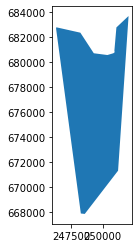

In [92]:
gpd.GeoSeries(
    [
        gsp_shape.loc[306],
        pv_metadata_with_gsp_id.loc[26715]["geometry"],
    ]
).plot()

In [93]:
pv_system_id_to_gsp_id = pv_metadata_with_gsp_id["gsp_id"]
pv_system_id_to_gsp_id

system_id
2405     130
2406      83
2407      83
2408      83
2409      83
        ... 
27063    109
27064     58
27065    109
27066    109
27067    299
Name: gsp_id, Length: 24662, dtype: int64

In [95]:
pv_system_id_to_gsp_id.isna().any()

False

In [96]:
pv_system_id_to_gsp_id.to_csv("passiv_pv_system_id_to_gsp_id.csv")

## Load satellite Zarr and compute GSP ID for each pixel

In [9]:
SAT_ZARR_PATH = "/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/satellite/EUMETSAT/SEVIRI_RSS/zarr/v2/eumetsat_zarr_*"

In [10]:
sat_dataset = xr.open_mfdataset(SAT_ZARR_PATH, engine="zarr")

In [12]:
sat_dataset.x

<xarray.DataArray 'x' (x: 615)>
array([1346210.550785, 1343059.920877, 1339909.246266, ..., -685027.855045,
       -688720.617123, -692415.553296])
Coordinates:
  * x        (x) float64 1.346e+06 1.343e+06 1.34e+06 ... -6.887e+05 -6.924e+05

In [13]:
sat_dataset.y

<xarray.DataArray 'y' (y: 298)>
array([-556688.12002 , -551640.567756, -546587.181054, ..., 1381214.144794,
       1390782.66111 , 1400395.155084])
Coordinates:
  * y        (y) float64 -5.567e+05 -5.516e+05 -5.466e+05 ... 1.391e+06 1.4e+06

In [18]:
import itertools

df_coords = pd.DataFrame(itertools.product(sat_dataset.x.values, sat_dataset.y.values), columns=['x', 'y'])

In [19]:
df_coords

,x,y
0,1.346211e+06,-5.566881e+05
1,1.346211e+06,-5.516406e+05
2,1.346211e+06,-5.465872e+05
3,1.346211e+06,-5.415279e+05
4,1.346211e+06,-5.364628e+05
...,...,...
183265,-6.924156e+05,1.362207e+06
183266,-6.924156e+05,1.371689e+06
183267,-6.924156e+05,1.381214e+06
183268,-6.924156e+05,1.390783e+06


In [25]:
gdf_coords = gpd.GeoDataFrame(df_coords, geometry=gpd.points_from_xy(df_coords.x, df_coords.y))

In [29]:
gdf_coords = gdf_coords.set_crs(epsg=OSGB_EPSG)

In [45]:
gdf_coords

,x,y,geometry
0,1.346211e+06,-5.566881e+05,POINT (1346210.551 -556688.120)
1,1.346211e+06,-5.516406e+05,POINT (1346210.551 -551640.568)
2,1.346211e+06,-5.465872e+05,POINT (1346210.551 -546587.181)
3,1.346211e+06,-5.415279e+05,POINT (1346210.551 -541527.937)
4,1.346211e+06,-5.364628e+05,POINT (1346210.551 -536462.811)
...,...,...,...
183265,-6.924156e+05,1.362207e+06,POINT (-692415.553 1362206.656)
183266,-6.924156e+05,1.371689e+06,POINT (-692415.553 1371689.005)
183267,-6.924156e+05,1.381214e+06,POINT (-692415.553 1381214.145)
183268,-6.924156e+05,1.390783e+06,POINT (-692415.553 1390782.661)


In [97]:
%%time
gdf_coords_with_gsp_id = gdf_coords.sjoin(
    gpd.GeoDataFrame(index=gsp_shape.index, geometry=gsp_shape, crs=gsp_shape.crs),
    how="left",
    predicate="within"
)

CPU times: user 534 ms, sys: 20.2 ms, total: 555 ms
Wall time: 554 ms


In [65]:
gdf_coords_with_gsp_id.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covers',
 'crosses',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [98]:
gdf_coords_with_gsp_id = gdf_coords_with_gsp_id.rename(columns={"index_right": "gsp_id"})
gdf_coords_with_gsp_id

,x,y,geometry,gsp_id
0,1.346211e+06,-5.566881e+05,POINT (1346210.551 -556688.120),NaN
1,1.346211e+06,-5.516406e+05,POINT (1346210.551 -551640.568),NaN
2,1.346211e+06,-5.465872e+05,POINT (1346210.551 -546587.181),NaN
3,1.346211e+06,-5.415279e+05,POINT (1346210.551 -541527.937),NaN
4,1.346211e+06,-5.364628e+05,POINT (1346210.551 -536462.811),NaN
...,...,...,...,...
183265,-6.924156e+05,1.362207e+06,POINT (-692415.553 1362206.656),NaN
183266,-6.924156e+05,1.371689e+06,POINT (-692415.553 1371689.005),NaN
183267,-6.924156e+05,1.381214e+06,POINT (-692415.553 1381214.145),NaN
183268,-6.924156e+05,1.390783e+06,POINT (-692415.553 1390782.661),NaN


In [102]:
duplicated = gdf_coords_with_gsp_id.index.duplicated()
gdf_coords_with_gsp_id.index[duplicated]

Int64Index([75229, 75230, 76124, 76125, 76718, 77016, 77017, 77314, 77612,
            77614,
            ...
            97287, 97332, 97580, 97581, 97582, 97584, 97585, 97878, 97879,
            97880],
           dtype='int64', length=209)

In [103]:
gdf_coords_with_gsp_id = gdf_coords_with_gsp_id.loc[~duplicated]
gdf_coords_with_gsp_id

,x,y,geometry,gsp_id
0,1.346211e+06,-5.566881e+05,POINT (1346210.551 -556688.120),NaN
1,1.346211e+06,-5.516406e+05,POINT (1346210.551 -551640.568),NaN
2,1.346211e+06,-5.465872e+05,POINT (1346210.551 -546587.181),NaN
3,1.346211e+06,-5.415279e+05,POINT (1346210.551 -541527.937),NaN
4,1.346211e+06,-5.364628e+05,POINT (1346210.551 -536462.811),NaN
...,...,...,...,...
183265,-6.924156e+05,1.362207e+06,POINT (-692415.553 1362206.656),NaN
183266,-6.924156e+05,1.371689e+06,POINT (-692415.553 1371689.005),NaN
183267,-6.924156e+05,1.381214e+06,POINT (-692415.553 1381214.145),NaN
183268,-6.924156e+05,1.390783e+06,POINT (-692415.553 1390782.661),NaN


In [107]:
%%time
pivoted = gdf_coords_with_gsp_id.pivot_table(
    index='y',
    columns='x',
    values='gsp_id',
    dropna=False,
)

CPU times: user 101 ms, sys: 8.16 ms, total: 109 ms
Wall time: 109 ms


In [111]:
# Sort the index and columns
pivoted = pivoted.reindex(index=np.sort(pivoted.index))

In [123]:
pivoted = pivoted.reindex(columns=np.sort(pivoted.columns))

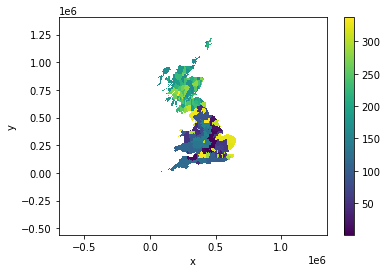

In [124]:
gsp_per_satellite_pixel = xr.DataArray(
    pivoted.values,
    dims=["y", "x"], 
    coords={"y": pivoted.index, "x": pivoted.columns},
).astype(np.float32)
gsp_per_satellite_pixel.plot()

In [128]:
gsp_per_satellite_pixel.to_dataset(name="data").to_netcdf("GSP_ID_per_satellite_pixel.nc")

In [129]:
!ls -alh GSP_ID_per_satellite_pixel.nc

-rw-rw-r-- 1 jack jack 724K Dec 15 17:54 GSP_ID_per_satellite_pixel.nc
